In [2]:
#pip install regionmask

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gp
import numpy as np
from shapely.geometry import MultiPolygon, Polygon

import regionmask
from xmip.regionmask import merged_mask

import pandas as pd
import gcsfs
import cmocean

fs = gcsfs.GCSFileSystem()
%run _Val_Mapping.ipynb

# Figure 1

## Define region masks

In [3]:
#from this webpage: https://www.marineregions.org

bering = gp.read_file('/home/jovyan/mCDR/shapefiles/bering.zip')
gulf = gp.read_file('/home/jovyan/mCDR/shapefiles/gulf.zip')
caribbean = gp.read_file('/home/jovyan/mCDR/shapefiles/caribbean.zip')

lon = np.arange(-180, 180,.1)
lat = np.arange(-90, 90,.1)

mask_bering = regionmask.mask_geopandas(bering, lon, lat)
mask_gulf = regionmask.mask_geopandas(gulf, lon, lat)
mask_caribbean = regionmask.mask_geopandas(caribbean, lon, lat)

## Bring in sampling masks

In [5]:
# SOCAT-2yr
mask_socat_01x01_2020_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2020-2022.zarr', engine="zarr")
mask_socat_01x01_2020_2022['socat_mask'] = mask_socat_01x01_2020_2022['socat_mask'].where(mask_socat_01x01_2020_2022['socat_mask'] > 0, np.nan)
socat_01x01_2020_2022  = mask_socat_01x01_2020_2022.sel(time=slice("2020-01-01",'2021-12-31')).mean(['time'])

# SOCAT-2yr+FLOAT
mask_socat_01x01_2020_2022_float = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2020-2022_float2.zarr', engine="zarr")
mask_socat_01x01_2020_2022_float['socat_mask'] = mask_socat_01x01_2020_2022_float['socat_mask'].where(mask_socat_01x01_2020_2022_float['socat_mask'] > 0, np.nan)
socat_01x01_2020_2022_float  = mask_socat_01x01_2020_2022_float.sel(time=slice("2020-01-01",'2021-12-31')).mean(['time'])

# SOCAT-23yr
mask_socat_01x01_2000_2022 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2000-2022_global.zarr', engine="zarr")
mask_socat_01x01_2000_2022['socat_mask'] = mask_socat_01x01_2000_2022['socat_mask'].where(mask_socat_01x01_2000_2022['socat_mask'] > 0, np.nan)
socat_01x01_2000_2022  = mask_socat_01x01_2000_2022.sel(time=slice("2021-01-01",'2021-12-31')).mean(['time'])

# SOCAT-23yr targeted 50-70 degrees north
mask_socat_01x01_2000_2022_lat_50_70 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2000-2022_lat_50_70.zarr', engine="zarr")
mask_socat_01x01_2000_2022_lat_50_70['socat_mask'] = mask_socat_01x01_2000_2022_lat_50_70['socat_mask'].where(mask_socat_01x01_2000_2022_lat_50_70['socat_mask'] > 0, np.nan)
socat_01x01_2000_2022_lat_50_70 = mask_socat_01x01_2000_2022_lat_50_70.sel(time=slice("2021-01-01",'2021-12-31')).mean(['time'])

### Increase size of float locations

In [7]:
float_only_mask = socat_01x01_2020_2022_float.socat_mask.where(socat_01x01_2020_2022.socat_mask != 1)

soc = socat_01x01_2020_2022.socat_mask.fillna(0).astype(bool)
flt = socat_01x01_2020_2022_float.socat_mask.fillna(0).astype(bool)

float_only_mask = flt & ~soc

float_only_mask = xr.DataArray(float_only_mask,
                               coords=socat_01x01_2020_2022.socat_mask.coords,
                               dims=socat_01x01_2020_2022.socat_mask.dims)

float_only_mask_nan = float_only_mask.where(float_only_mask == 1)

lat = float_only_mask['latitude']
lon = float_only_mask['longitude']
lon_grid, lat_grid = np.meshgrid(lon, lat)

## Figure 1a

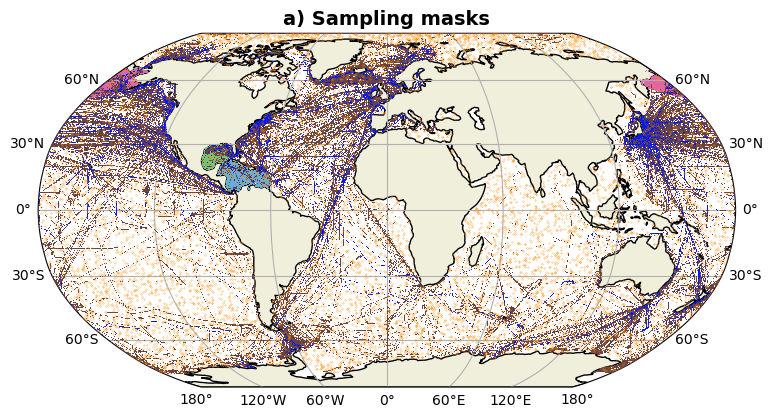

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Robinson())  

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = True

ax.add_feature(cartopy.feature.LAND, edgecolor='black')

mask_bering.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='PuRd')
mask_gulf.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Greens')
mask_caribbean.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, cmap='Blues')

mask_points = float_only_mask.values.astype(bool)

ax.scatter(lon_grid[mask_points], lat_grid[mask_points],
           transform=ccrs.PlateCarree(), s=0.05, color='darkorange',
           zorder=11, label='Float only')

socat_01x01_2000_2022.socat_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='pink', vmin=0, vmax=10, zorder=10, add_colorbar=False)
socat_01x01_2020_2022.socat_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='winter', vmin=0, vmax=10, zorder=10, add_colorbar=False)

ax.set_title("a) Sampling masks", fontsize=14, weight='bold');
#plt.savefig("/home/jovyan/mask_global.jpg",dpi=300, bbox_inches="tight", transparent=True)

## Figure 1b

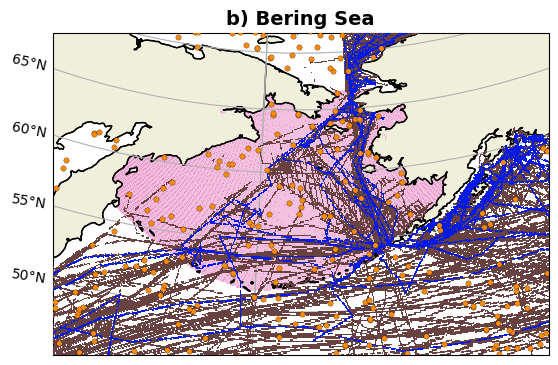

In [22]:
central_lon = -96
central_lat = 45
extent = [-200, -150, 45, 70] 

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False                                                             

### Regional mask ###
mask_bering.plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False, cmap='PuRd', alpha= 0.4)

### Sampling mask ###
socat_01x01_2000_2022.socat_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='pink',vmin=0, vmax=10,zorder=10,add_colorbar=False)
socat_01x01_2020_2022.socat_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='winter',vmin=0, vmax=10,zorder=10,add_colorbar=False)

mask_points = float_only_mask.values.astype(bool)

ax.scatter(lon_grid[mask_points], lat_grid[mask_points],
           transform=ccrs.PlateCarree(), s=15, edgecolors='black', linewidth=0.2, color='darkorange',
           zorder=11, label='Float only')

plt.title('b) Bering Sea', fontsize=14, fontweight='bold'); 
#plt.savefig("/home/jovyan/mask_Bering.jpg",dpi=300, bbox_inches="tight")

## Figure 1c

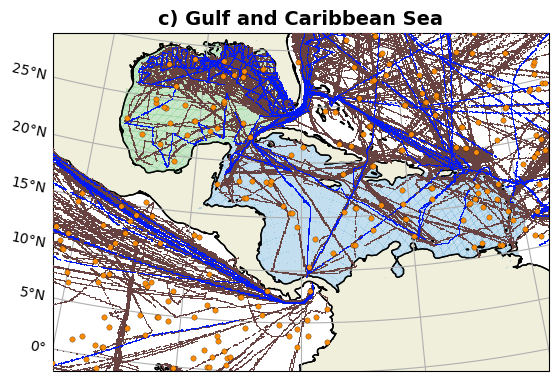

In [16]:
central_lon = -96
central_lat = 45
extent = [-100, -60, 0, 30] 

central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False                                                             

### Regional mask ###
mask_caribbean.plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False, cmap='Blues', alpha= 0.4)
mask_gulf.plot(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False, cmap='Greens', alpha= 0.4)

### Sampling mask ###
socat_01x01_2000_2022.socat_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='pink',vmin=0, vmax=10,zorder=10,add_colorbar=False)
socat_01x01_2020_2022.socat_mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='winter',vmin=0, vmax=10,zorder=10,add_colorbar=False)

mask_points = float_only_mask.values.astype(bool)

ax.scatter(lon_grid[mask_points], lat_grid[mask_points],
           transform=ccrs.PlateCarree(), s=15, edgecolors='black', linewidth=0.2, color='darkorange',
           zorder=11, label='Float only')

plt.title('c) Gulf and Caribbean Sea', fontsize=14, fontweight='bold'); 
#plt.savefig("/home/jovyan/mask_gulf_carib.jpg",dpi=300, bbox_inches="tight")

## Calculate sampling coverage for specific regions

In [3]:
# Rename variables so that region masks match sampling masks
mask_bering_01x01  = mask_bering.to_dataset().rename({"lon":"longitude", "lat": "latitude"})
mask_gulf_01x01  = mask_gulf.to_dataset().rename({"lon":"longitude", "lat": "latitude"})
mask_caribbean_01x01 = mask_caribbean.to_dataset().rename({"lon":"longitude", "lat": "latitude"})

In [6]:
# Open HR-CESM-testbed reconstruction file to get the full grid 
testbed_01x01 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/post02_xgb_output/2022_global/reconstructions/recon_pCO2_nmse_mon_01x01_202002-202201.zarr', engine='zarr').sel(time=slice("2020-02-01",'2021-12-31'))

In [10]:
# Apply region masks in the HR-CESM-testbed
testbed_01x01_bering  = testbed_01x01.where(mask_bering_01x01.mask.values==0.)
testbed_01x01_gulf  = testbed_01x01.where(mask_gulf_01x01.mask.values==0.)
testbed_01x01_caribbean  = testbed_01x01.where(mask_caribbean_01x01.mask.values==0.)

In [11]:
# Calculate all possible grid cells in the HR-CESM-testbed globally or over specific regions
testbed_size_01x01_full = np.count_nonzero(~np.isnan(testbed_01x01.pco2_recon_full.sel(time=slice("2020-02-01",'2022-01-01'))))
testbed_size_01x01_bering = np.count_nonzero(~np.isnan(testbed_01x01_bering.pco2_recon_full.sel(time=slice("2020-02-01",'2022-01-01'))))
testbed_size_01x01_gulf = np.count_nonzero(~np.isnan(testbed_01x01_gulf.pco2_recon_full.sel(time=slice("2020-02-01",'2022-01-01'))))
testbed_size_01x01_caribbean = np.count_nonzero(~np.isnan(testbed_01x01_caribbean.pco2_recon_full.sel(time=slice("2020-02-01",'2022-01-01'))))

In [14]:
# Apply region mask on sampling masks to get number of observations for each region
mask_socat_01x01_2000_2022_bering  = mask_socat_01x01_2000_2022.where(mask_bering_01x01.mask.values==0.)
mask_socat_01x01_2000_2022_gulf  = mask_socat_01x01_2000_2022.where(mask_gulf_01x01.mask.values==0.)
mask_socat_01x01_2000_2022_caribbean  = mask_socat_01x01_2000_2022.where(mask_caribbean_01x01.mask.values==0.)

mask_socat_01x01_2020_2022_bering  = mask_socat_01x01_2020_2022.where(mask_bering_01x01.mask.values==0.)
mask_socat_01x01_2020_2022_gulf  = mask_socat_01x01_2020_2022.where(mask_gulf_01x01.mask.values==0.)
mask_socat_01x01_2020_2022_caribbean  = mask_socat_01x01_2020_2022.where(mask_caribbean_01x01.mask.values==0.)

mask_socat_01x01_2020_2022_bering_float  = mask_socat_01x01_2020_2022_float.where(mask_bering_01x01.mask.values==0.)
mask_socat_01x01_2020_2022_gulf_float  = mask_socat_01x01_2020_2022_float.where(mask_gulf_01x01.mask.values==0.)
mask_socat_01x01_2020_2022_caribbean_float  = mask_socat_01x01_2020_2022_float.where(mask_caribbean_01x01.mask.values==0.)

In [12]:
# Calculate sampling coverage globally for the three sampling masks
socat_mask_size_01x01_2020_2021 = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2020_2021_float = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2000_2021 = np.count_nonzero(~np.isnan(mask_socat_01x01_2000_2022.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))

percentage_mask_01x01_2020_2021= (np.divide(socat_mask_size_01x01_2020_2021, testbed_size_01x01_full)) * 100
percentage_mask_01x01_2020_2021_float = (np.divide(socat_mask_size_01x01_2020_2021_float, testbed_size_01x01_full)) * 100
percentage_mask_01x01_2000_2021 = (np.divide(socat_mask_size_01x01_2000_2021, testbed_size_01x01_full)) * 100

print(percentage_mask_01x01_2020_2021)
print(percentage_mask_01x01_2020_2021_float)
print(percentage_mask_01x01_2000_2021)

0.46884386980722437
0.7337896392585485
3.9079237866461045


In [15]:
# Calculate sampling coverage for specific regions for SOCAT-2yr
socat_mask_size_01x01_2020_2021_bering = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_bering.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2020_2021_gulf = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_gulf.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2020_2021_caribbean = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_caribbean.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))

percentage_mask_01x01_2020_2021_bering = (np.divide(socat_mask_size_01x01_2020_2021_bering, testbed_size_01x01_bering)) * 100
percentage_mask_01x01_2020_2021_gulf = (np.divide(socat_mask_size_01x01_2020_2021_gulf, testbed_size_01x01_gulf)) * 100
percentage_mask_01x01_2020_2021_caribbean = (np.divide(socat_mask_size_01x01_2020_2021_caribbean, testbed_size_01x01_caribbean)) * 100

print(percentage_mask_01x01_2020_2021_bering)
print(percentage_mask_01x01_2020_2021_gulf)
print(percentage_mask_01x01_2020_2021_caribbean)

1.0386230111307853
2.4870600414078674
0.8099861514814871


In [16]:
# Calculate sampling coverage for specific regions for SOCAT-2yr+FLOAT
socat_mask_size_01x01_2020_2021_bering_float = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_bering_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2020_2021_gulf_float = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_gulf_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2020_2021_caribbean_float = np.count_nonzero(~np.isnan(mask_socat_01x01_2020_2022_caribbean_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))

percentage_mask_01x01_2020_2021_bering_float = (np.divide(socat_mask_size_01x01_2020_2021_bering_float, testbed_size_01x01_bering)) * 100
percentage_mask_01x01_2020_2021_gulf_float = (np.divide(socat_mask_size_01x01_2020_2021_gulf_float, testbed_size_01x01_gulf)) * 100
percentage_mask_01x01_2020_2021_caribbean_float = (np.divide(socat_mask_size_01x01_2020_2021_caribbean_float, testbed_size_01x01_caribbean)) * 100

print(percentage_mask_01x01_2020_2021_bering_float)
print(percentage_mask_01x01_2020_2021_gulf_float)
print(percentage_mask_01x01_2020_2021_caribbean_float)

1.329437454247405
2.7406832298136647
1.0671729238635845


In [17]:
# Calculate sampling coverage for specific regions for SOCAT-23yr
socat_mask_size_01x01_2000_2021_bering = np.count_nonzero(~np.isnan(mask_socat_01x01_2000_2022_bering.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2000_2021_gulf = np.count_nonzero(~np.isnan(mask_socat_01x01_2000_2022_gulf.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))
socat_mask_size_01x01_2000_2021_caribbean = np.count_nonzero(~np.isnan(mask_socat_01x01_2000_2022_caribbean.socat_mask.sel(time=slice("2020-02-01",'2022-01-01'))))

percentage_mask_01x01_2000_2021_bering = (np.divide(socat_mask_size_01x01_2000_2021_bering, testbed_size_01x01_bering)) * 100
percentage_mask_01x01_2000_2021_gulf = (np.divide(socat_mask_size_01x01_2000_2021_gulf, testbed_size_01x01_gulf)) * 100
percentage_mask_01x01_2000_2021_caribbean = (np.divide(socat_mask_size_01x01_2000_2021_caribbean, testbed_size_01x01_caribbean)) * 100

print(percentage_mask_01x01_2000_2021_bering)
print(percentage_mask_01x01_2000_2021_gulf)
print(percentage_mask_01x01_2000_2021_caribbean)

5.991228015291534
17.976190476190474
11.744608969578914


## Figure 2

In [18]:
# Groupby monthly observations for histograms
# SOCAT-23yr
socat_full_2000_2022_month = mask_socat_01x01_2000_2022.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_bering_2000_2022_month = mask_socat_01x01_2000_2022_bering.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_gulf_2000_2022_month = mask_socat_01x01_2000_2022_gulf.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_caribbean_2000_2022_month = mask_socat_01x01_2000_2022_caribbean.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])

dffull_01x01_2000_2022_month = pd.DataFrame(socat_full_2000_2022_month, index=socat_full_2000_2022_month.month,columns=['SOCAT_2000-2021'])
dfbering_01x01_2000_2022_month = pd.DataFrame(socat_bering_2000_2022_month, index=socat_bering_2000_2022_month.month,columns=['Bering Sea'])
dfgulf_01x01_2000_2022_month = pd.DataFrame(socat_gulf_2000_2022_month, index=socat_gulf_2000_2022_month.month,columns=['The Gulf'])
dfcaribbean_01x01_2000_2022_month = pd.DataFrame(socat_caribbean_2000_2022_month, index=socat_caribbean_2000_2022_month.month,columns=['Caribbean Sea'])

# SOCAT-2yr
socat_full_2020_2022_month = mask_socat_01x01_2020_2022.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_bering_2020_2022_month = mask_socat_01x01_2020_2022_bering.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_gulf_2020_2022_month = mask_socat_01x01_2020_2022_gulf.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_caribbean_2020_2022_month = mask_socat_01x01_2020_2022_caribbean.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])

dffull_01x01_2020_2022_month = pd.DataFrame(socat_full_2020_2022_month, index=socat_full_2020_2022_month.month,columns=['SOCAT_2020-2021'])
dfbering_01x01_2020_2022_month = pd.DataFrame(socat_bering_2020_2022_month, index=socat_bering_2020_2022_month.month,columns=['SOCAT_2020-2021-Bering'])
dfgulf_01x01_2020_2022_month = pd.DataFrame(socat_gulf_2020_2022_month, index=socat_gulf_2020_2022_month.month,columns=['The Gulf'])
dfcaribbean_01x01_2020_2022_month = pd.DataFrame(socat_caribbean_2020_2022_month, index=socat_caribbean_2020_2022_month.month,columns=['SOCAT_2020-2021-Caribbean'])

# SOCAT-2yr+FLOAT
socat_full_2020_2022_month_float = mask_socat_01x01_2020_2022_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_bering_2020_2022_month_float = mask_socat_01x01_2020_2022_bering_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_gulf_2020_2022_month_float = mask_socat_01x01_2020_2022_gulf_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])
socat_caribbean_2020_2022_month_float = mask_socat_01x01_2020_2022_caribbean_float.socat_mask.sel(time=slice("2020-02-01",'2022-01-01')).groupby('time.month').count().sum(['latitude','longitude'])

dffull_01x01_2020_2022_month_float = pd.DataFrame(socat_full_2020_2022_month_float, index=socat_full_2020_2022_month_float.month,columns=['SOCAT_2020-2021_float'])
dfbering_01x01_2020_2022_month_float = pd.DataFrame(socat_bering_2020_2022_month_float, index=socat_bering_2020_2022_month_float.month,columns=['SOCAT_2020-2021-Bering_float'])
dfgulf_01x01_2020_2022_month_float = pd.DataFrame(socat_gulf_2020_2022_month_float, index=socat_gulf_2020_2022_month_float.month,columns=['The Gulf'])
dfcaribbean_01x01_2020_2022_month_float = pd.DataFrame(socat_caribbean_2020_2022_month_float, index=socat_caribbean_2020_2022_month_float.month,columns=['SOCAT_2020-2021-Caribbean_float'])

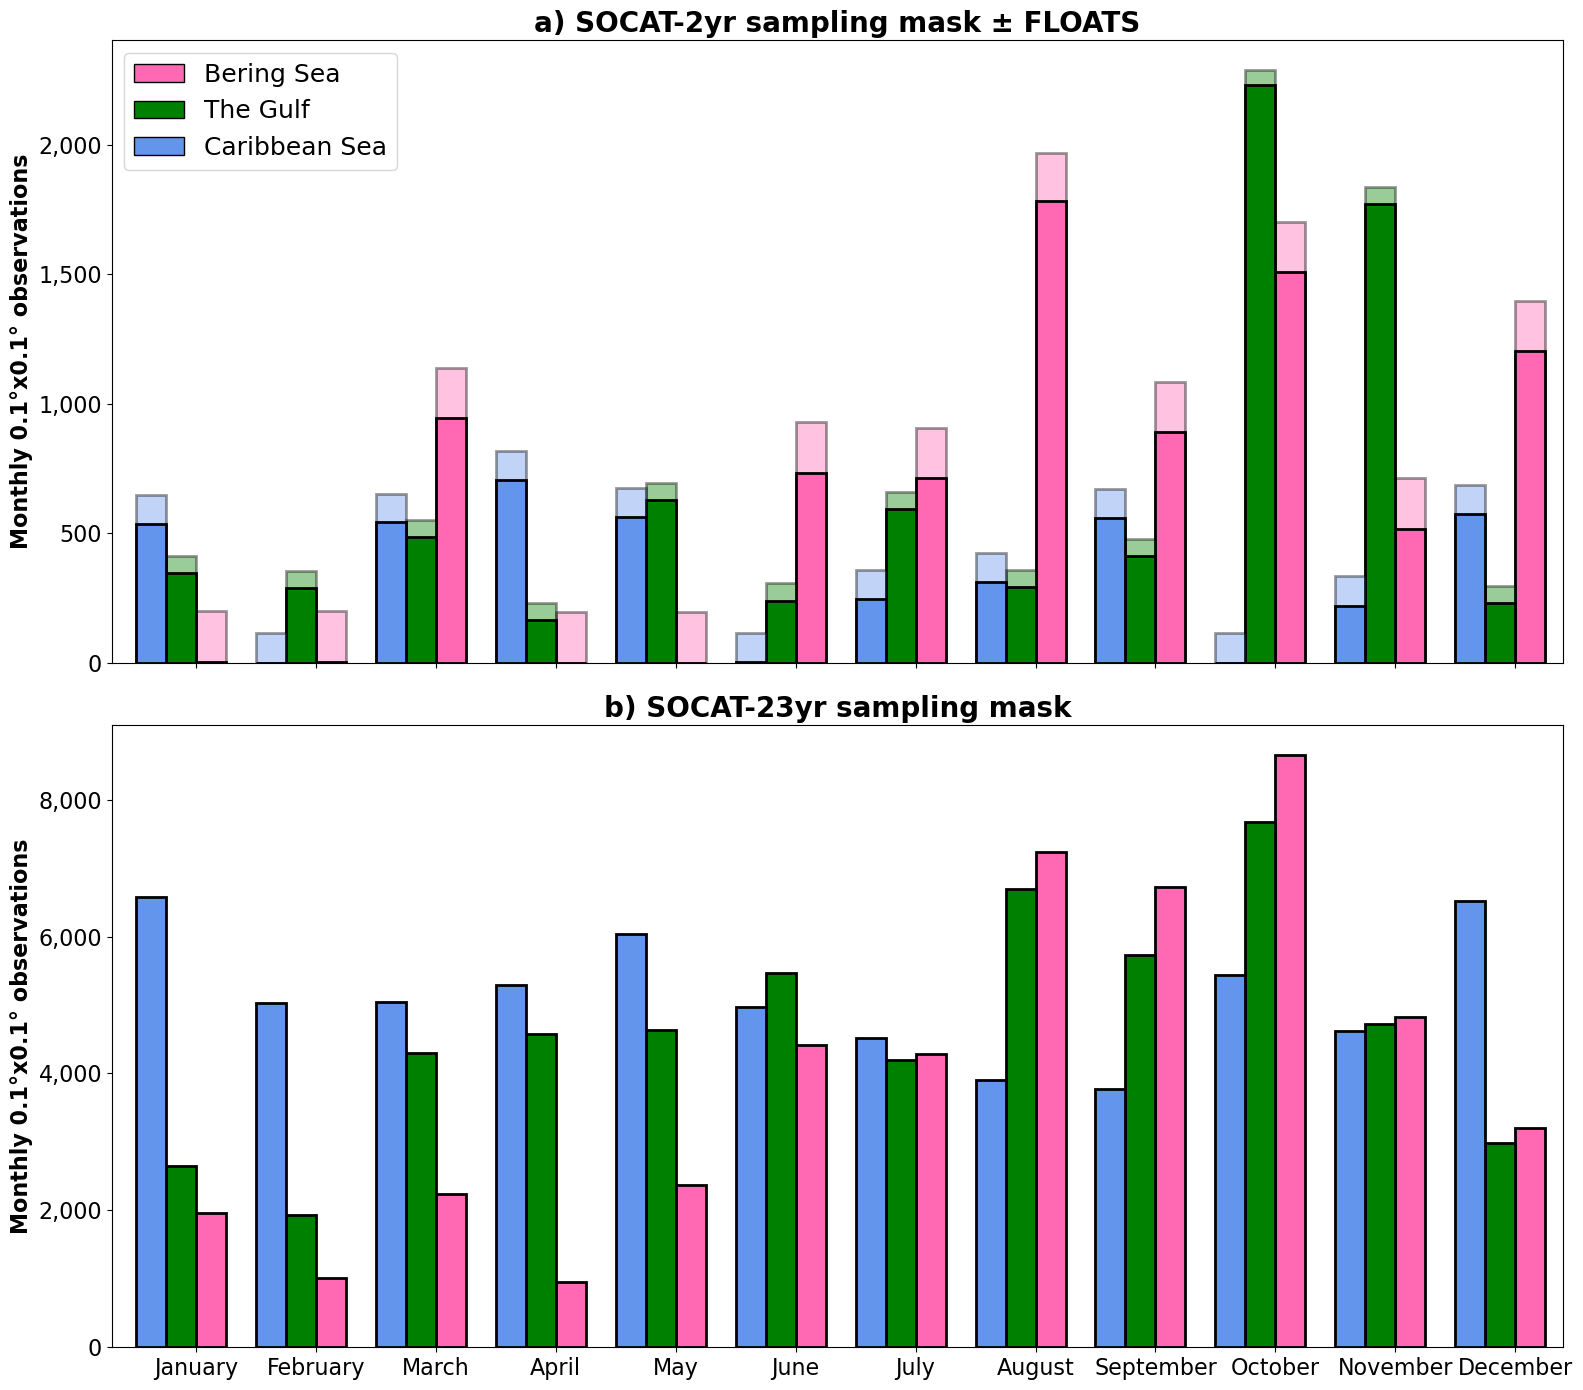

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

month_names = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

color_list_2000_2022_bering = ['hotpink']
color_list_2020_2022_gulf = ['green']
color_list_2020_2022_caribbean = ['cornflowerblue']
edgecolor = ['black']
width = 0.25

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14), sharex=True)

# --- Panel a ---
dfbering_01x01_2020_2022_month_float.plot(kind='bar', ax=ax1, color=color_list_2000_2022_bering, width=width, position=0, 
                   edgecolor=edgecolor, linewidth=2, label='2000', fontsize=14, alpha=0.4)
dfbering_01x01_2020_2022_month.plot(kind='bar', ax=ax1, color=color_list_2000_2022_bering, width=width, position=0,
                   edgecolor=edgecolor, linewidth=2, fontsize=14, align='center')

dfgulf_01x01_2020_2022_month_float.plot(kind='bar', ax=ax1, color=color_list_2020_2022_gulf, width=width, position=1, 
                   edgecolor=edgecolor, linewidth=2, label='3000', fontsize=14, alpha=0.4)
dfgulf_01x01_2020_2022_month.plot(kind='bar', ax=ax1, color=color_list_2020_2022_gulf, width=width, position=1,
                   edgecolor=edgecolor, linewidth=2, fontsize=14, align='center')

dfcaribbean_01x01_2020_2022_month_float.plot(kind='bar', ax=ax1, color=color_list_2020_2022_caribbean, width=width, position=2, 
                   edgecolor=edgecolor, linewidth=2, label='2000', fontsize=14, alpha=0.4)
dfcaribbean_01x01_2020_2022_month.plot(kind='bar', ax=ax1, color=color_list_2020_2022_caribbean, width=width, position=2, 
                   edgecolor=edgecolor, linewidth=2, fontsize=14, align='center')

ax1.set_ylabel('Monthly 0.1°x0.1° observations', fontsize=16, fontweight="bold")
ax1.set_title('a) SOCAT-2yr sampling mask ± FLOATS', fontsize=20, fontweight="bold")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax1.tick_params(axis='y', labelsize=16)
ax1.set_xlim(-0.7, len(month_names) - 0.6)
ax1.margins(x=0.05)

from matplotlib.patches import Patch

custom_legend = [
    Patch(facecolor='hotpink', edgecolor='black', label='Bering Sea'),
    Patch(facecolor='green', edgecolor='black', label='The Gulf'),
    Patch(facecolor='cornflowerblue', edgecolor='black', label='Caribbean Sea')
]
ax1.legend(handles=custom_legend, fontsize=18, loc='upper left')

# --- Panel b ---
dfbering_01x01_2000_2022_month.plot(kind='bar', ax=ax2, color=color_list_2000_2022_bering, width=width, position=0, 
                   edgecolor=edgecolor, linewidth=2, label='2000', fontsize=14)
dfgulf_01x01_2000_2022_month.plot(kind='bar', ax=ax2, color=color_list_2020_2022_gulf, width=width, position=1, 
                   edgecolor=edgecolor, linewidth=2, label='2020', fontsize=14)
dfcaribbean_01x01_2000_2022_month.plot(kind='bar', ax=ax2, color=color_list_2020_2022_caribbean, width=width, position=2, 
                   edgecolor=edgecolor, linewidth=2, label='2022', fontsize=14)

ax2.set_ylabel('Monthly 0.1°x0.1° observations', fontsize=16, fontweight="bold")
ax2.set_title('b) SOCAT-23yr sampling mask', fontsize=20, fontweight="bold")
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.tick_params(axis='y', labelsize=16)
ax2.set_xticks(range(len(month_names)))
ax2.set_xticklabels(month_names, fontsize=16, rotation=0)
ax2.tick_params(axis='x', labelsize=16)
ax2.set_xlim(-0.7, len(month_names) - 0.6)
ax2.margins(x=0.01)
ax2.get_legend().remove()
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
#plt.savefig("/home/jovyan/barplot_regions_monthly.jpg", dpi=300, bbox_inches="tight")

## Figure 8

In [4]:
# Get SST from HR-CESM-testbed
sst = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/SST_monthly_202002-202201.zarr', engine='zarr')

# Get sampling masks
mask_socat_01x01_2000_2021 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2000-2022_global.zarr', engine="zarr")
mask_socat_01x01_2020_2021 = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2020-2022.zarr', engine="zarr")
mask_socat_01x01_2020_2021_float = xr.open_dataset('gs://leap-persistent/abbysh/ncar_files/processed/socat_mask_monthly_10th_2020-2022_float2.zarr', engine="zarr")

In [5]:
# Apply region masks on SST data
sst_bering  = sst.insitu_temp.where(mask_bering.values==0.)
sst_caribbean  = sst.insitu_temp.where(mask_caribbean.values==0.)
sst_gulf  = sst.insitu_temp.where(mask_gulf.values==0.)

In [6]:
# Apply SST region masks for the three experiments
sst_bering_socat_2yr = sst_bering.where(mask_socat_01x01_2020_2021.socat_mask.values==1.)
sst_caribbean_socat_2yr = sst_caribbean.where(mask_socat_01x01_2020_2021.socat_mask.values==1.)
sst_gulf_socat_2yr = sst_gulf.where(mask_socat_01x01_2020_2021.socat_mask.values==1.)

sst_bering_socat_float = sst_bering.where(mask_socat_01x01_2020_2021_float.socat_mask.values==1.)
sst_caribbean_socat_float = sst_caribbean.where(mask_socat_01x01_2020_2021_float.socat_mask.values==1.)
sst_gulf_socat_float = sst_gulf.where(mask_socat_01x01_2020_2021_float.socat_mask.values==1.)

sst_bering_socat_23yr = sst_bering.where(mask_socat_01x01_2000_2021.socat_mask.values==1.)
sst_caribbean_socat_23yr = sst_caribbean.where(mask_socat_01x01_2000_2021.socat_mask.values==1.)
sst_gulf_socat_23yr = sst_gulf.where(mask_socat_01x01_2000_2021.socat_mask.values==1.)

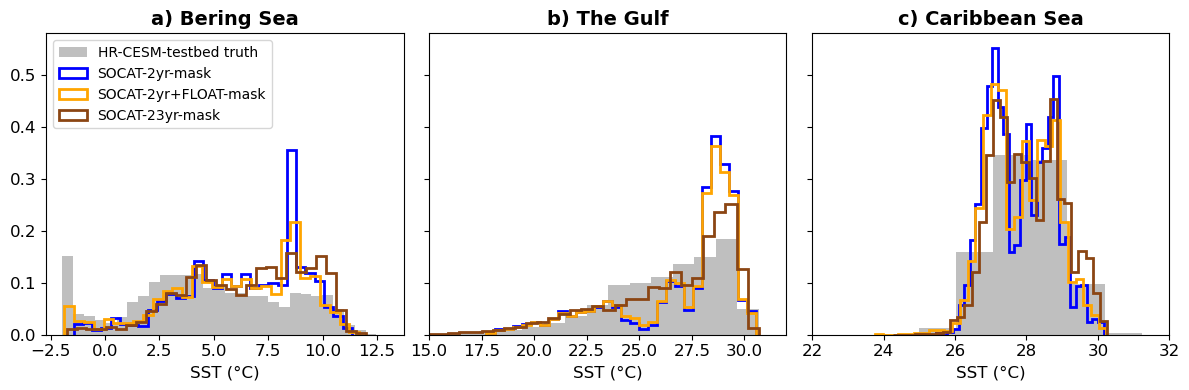

In [8]:
data_bering_20 = sst_bering.values.flatten()
data_bering_21 = sst_bering_socat_2yr.values.flatten()
data_bering_22 = sst_bering_socat_float.values.flatten()
data_bering_23 = sst_bering_socat_23yr.values.flatten()

data_bering_20 = data_bering_20[~np.isnan(data_bering_20)]
data_bering_21 = data_bering_21[~np.isnan(data_bering_21)]
data_bering_22 = data_bering_22[~np.isnan(data_bering_22)]
data_bering_23 = data_bering_23[~np.isnan(data_bering_23)]

data_caribbean_20 = sst_caribbean.values.flatten()
data_caribbean_21 = sst_caribbean_socat_2yr.values.flatten()
data_caribbean_22 = sst_caribbean_socat_float.values.flatten()
data_caribbean_23 = sst_caribbean_socat_23yr.values.flatten()

data_caribbean_20 = data_caribbean_20[~np.isnan(data_caribbean_20)]
data_caribbean_21 = data_caribbean_21[~np.isnan(data_caribbean_21)]
data_caribbean_22 = data_caribbean_22[~np.isnan(data_caribbean_22)]
data_caribbean_23 = data_caribbean_23[~np.isnan(data_caribbean_23)]

data_gulf_20 = sst_gulf.values.flatten()
data_gulf_21 = sst_gulf_socat_2yr.values.flatten()
data_gulf_22 = sst_gulf_socat_float.values.flatten()
data_gulf_23 = sst_gulf_socat_23yr.values.flatten()

data_gulf_20 = data_gulf_20[~np.isnan(data_gulf_20)]
data_gulf_21 = data_gulf_21[~np.isnan(data_gulf_21)]
data_gulf_22 = data_gulf_22[~np.isnan(data_gulf_22)]
data_gulf_23 = data_gulf_23[~np.isnan(data_gulf_23)]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axes[0].hist(data_bering_20, bins=30, alpha=0.5, label="HR-CESM-testbed truth", density=True, color='gray')
axes[0].hist(data_bering_21, bins=30, histtype='step', linewidth=2, label="SOCAT-2yr-mask", density=True, color='blue')
axes[0].hist(data_bering_22, bins=30, histtype='step', linewidth=2, label="SOCAT-2yr+FLOAT-mask", density=True, color='orange')
axes[0].hist(data_bering_23, bins=30, histtype='step', linewidth=2, label="SOCAT-23yr-mask", density=True, color='saddlebrown')
axes[0].set_title("a) Bering Sea", fontsize=14, fontweight='bold')
axes[0].set_xlabel("SST (°C)", fontsize=12)
axes[0].legend(loc="upper left")

axes[1].hist(data_gulf_20, bins=30, alpha=0.5, label="HR-CESM-testbed truth", density=True, color='gray')
axes[1].hist(data_gulf_21, bins=30, histtype='step', linewidth=2, label="SOCAT-2yr-mask", density=True, color='blue')
axes[1].hist(data_gulf_22, bins=30, histtype='step', linewidth=2, label="SOCAT-2yr+FLOAT-mask", density=True, color='orange')
axes[1].hist(data_gulf_23, bins=30, histtype='step', linewidth=2, label="SOCAT-23yr-mask", density=True, color='saddlebrown')
axes[1].set_title("b) The Gulf", fontsize=14, fontweight='bold')
axes[1].set_xlabel("SST (°C)", fontsize=12)
axes[1].set_xlim([15, 32])

axes[2].hist(data_caribbean_20, bins=30, alpha=0.5, label="HR-CESM-testbed truth", density=True, color='gray')
axes[2].hist(data_caribbean_21, bins=30, histtype='step', linewidth=2, label="SOCAT-2yr-mask", density=True, color='blue')
axes[2].hist(data_caribbean_22, bins=30, histtype='step', linewidth=2, label="SOCAT-2yr+FLOAT-mask", density=True, color='orange')
axes[2].hist(data_caribbean_23, bins=30, histtype='step', linewidth=2, label="SOCAT-23yr-mask", density=True, color='saddlebrown')
axes[2].set_title("c) Caribbean Sea", fontsize=14, fontweight='bold')
axes[2].set_xlabel("SST (°C)", fontsize=12)
axes[2].set_xlim([22, 32])

for ax in axes:
    ax.tick_params(axis='both', labelsize=12)  # Increase tick label font size

plt.tight_layout();
#plt.savefig("/home/jovyan/timeseries_sst.jpg",dpi=300, bbox_inches="tight")

## Figure S3

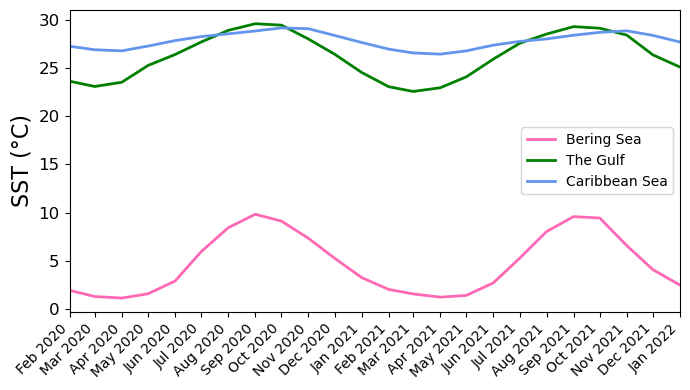

In [8]:
test = sst_bering.mean(['latitude', 'longitude'])
test2 = sst_gulf.mean(['latitude', 'longitude'])
test3 = sst_caribbean.mean(['latitude', 'longitude'])

time_values = pd.to_datetime(test.time.values)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(time_values, test, linewidth=2.0, color='hotpink',label='Bering Sea')
ax.plot(time_values, test2, linewidth=2.0, color='green',label='The Gulf')
ax.plot(time_values, test3, linewidth=2.0, color='cornflowerblue',label='Caribbean Sea')

ax.set_xticks(time_values)  
ax.set_xticklabels(time_values.strftime('%b %Y'), rotation=45, ha='right') 

ax.set_ylabel("SST (°C)", fontsize=16)
ax.set_xlim(time_values[0], time_values[-1])
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.legend();
#plt.savefig("/home/jovyan/sst.jpg",dpi=300, bbox_inches="tight")